# Clasificación y agrupación de Radio Galaxias

En el problema de clasificación y agrupación de radio galaxias nos topamos con problemas que también existen cuando se utilizan imágenes de otros tipos, principalmente es generar un algoritmo que nos permita analizar las imágenes de una forma invariante a rotación, translación e idealmente a escalas.

En los papers leidos pudimos ver que Self Organizing Maps (SOM) tiene cierta popularidad en el area de agrupación de radio galaxias. Para evitar problemas por translación, todas las imágenes están centradas sobre la fuente emisora. El problema de rotación es algo más complejo, pero se toma un camino considerablemente sencillo y computacionalmente pesado, generar rotaciones de las imágenes originales. En Galvin et al generan imagenes de ratación de 1, obteniendo así 360 imágenes, teniendo estas imágenes se utilizan distancias Euclidianas para el SOM, tomando las distancias menores entre los grupos de 360 imágenes, es decir, por cada dato se usan 360 imágenes para los calculos. Como pudimos ver en Polsterer et al, este proceso puede ser muy tardado, especialmente si no se paraleliza de manera adecuada.

El otro camino seguido, propuesto en Ralph et al, introduce una red neuronal convolucionada como Auto-Encoder, de esta forma pasamos los datos a un espacio más simple, al igual que Galvin, se utilizan imágenes rotadas, pero en este caso se usan rotaciones aleatorias, de esta forma usan menos imágenes que Galvin, pero se obtienen los beneficios. Despues de entrenar la red neuronal se hace un SOM con los datos codificados, el SOM es muchó más rápido, ya que maneja mucho menos datos, pero el entrenamiento de la Red Neuronal es algo tardado.

## Propuestas

Nos gustaría generar un nuevo algorimo que nos permita agrupar las radio galaxias que sea invariante a rotación, a su vez nos gustaría algo más sencillo que rotar las imágenes un grado, creando un conjuto de datos considerablemente más grande que el original. Actualmente tenemos dos opciones.

### Cambio de métrica de distancia
Tanto Galvin como Ralph usan la distancia Euclidiana para realizar SOM, el problema con esta métrica es que es sensible a translación y rotación, pero existen otras métricas que nos podrían ser útiles. 

#### Procrustes Shape Distance
 Para esta métrica comenzamos buscando la imágen promedio, y rotamos todas las demás imágenes de tal forma que minimizamos la distancia euclediana entre ellas y la imágen promedio. Este proceso se repite hasta que la imágen promedio no cambie. 
 Lamentablemente este proceso podría llegar a ser muy tardado y no nos daría una ventaja sobre los algoritmos ya existentes, sin embargo podríamos utilizar un subconjuto de los datos para generar la imágen promedio y rotar el resto de los datos usando esta imágen promedio. Teniendo todas las imágenes rotadas podemos usar SOM o algún otro método que nos permita vizualizar, como ISOMAP, K-Means, etc.
 
### Análisis Morfológico

Si logramos extraer información invariente a rotación y translación de nuestras imágenes, podríamos el análisis sólo sobre esta información, de esta forma no necesitaríamos rotar las imagenes lo cual posiblemente nos ahorraría tiempo.

Una forma de obtener algo de información invariante bajo transalación y rotación es tomar un elemento estructurante circular, conservar el area sobre la cual este cabe y comprarar los cambios de area, esta operación es equivalente a un Opening morfológico, podemos tomar diferentes tamaños y así obtener bastante información.

Otra opción sería tomar el elemento estructurante y pasarlo sobre el contorno de la forma, de esta forma agrandando la forma. Tambíen podríamos usar ambas técnicas en conjunto, obteniendo así más información.

#### Ejemplos
En los siguentes ejemplos usaremos el conjunto de datos MNIST ya que estos son más fáciles de manejar y las categorías son facilmente distinguibles

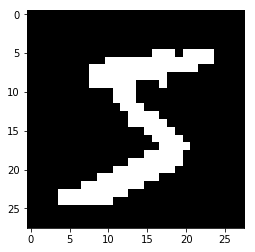

In [19]:
from keras.datasets import mnist #usamos keras para descargar MNIST
import matplotlib.pyplot as plt #matplotlib para graficar
from numba import jit #easy paralleization
(x_train, y_train), (x_test, y_test) = mnist.load_data()
im1 = x_train[0] > 50 #umbral fijo para el ejemplo
plt.imshow(im1, cmap='gray')
plt.show()

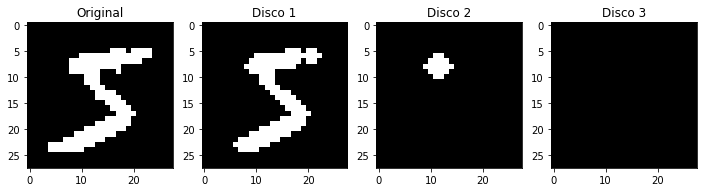

In [2]:
import skimage.morphology as morpho
f, ax = plt.subplots(1, 4, figsize=(12,15))
ax[0].imshow(im1, cmap='gray') #umbral fijo para el ejemplo
ax[0].set_title('Original')
for i in range(1, 4):
    d1 = morpho.disk(i)
    imo = morpho.opening(im1, d1)
    ax[i].imshow(imo, cmap='gray')
    st = 'Disco ' + str(i)
    ax[i].set_title(st)
plt.show()

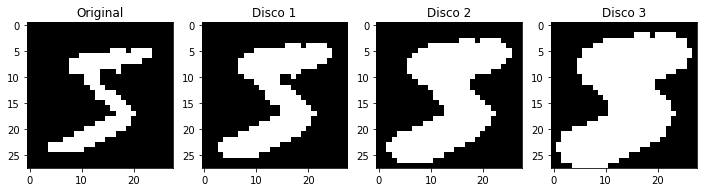

In [3]:
import skimage.morphology as morpho
f, ax = plt.subplots(1, 4, figsize=(12,15))
ax[0].imshow(im1, cmap='gray') #umbral fijo para el ejemplo
ax[0].set_title('Original')
for i in range(1, 4):
    d1 = morpho.disk(i)
    imo = morpho.dilation(im1, d1)
    ax[i].imshow(imo, cmap='gray')
    st = 'Disco ' + str(i)
    ax[i].set_title(st)
plt.show()

Podemos aplicar las mismas operaciones sobre imágenes de radio galaxias, pero para evitar hacer umbralizados debemos usar un elemento estructurante que no sólo sea blanco y negro. Si vemos una imágen como un objeto tridimencional, donde la intensidad de cada pixel es el tercer eje, podemos aplicar los operadores morfológicos en tres dimenciones.

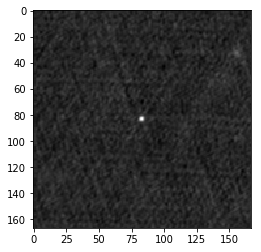

In [28]:
fits_dir = '../imgs/first' #directorio donde tenemos imagenes FIRST
from astropy.io import fits
import skimage as sk
im = fits.open('{0}/J145615+605322.fits'.format(fits_dir))
plt.imshow(im[0].data, cmap='gray')
plt.show()

In [45]:
%%time
import numpy as np
@jit(nopython=True)
def discretize_img(img, n_div):
    min_b, max_b = 10, -100
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(img[i,j] < min_b): min_b = img[i,j]
            if(img[i,j] > max_b): max_b = img[i,j]
    discrete_sz = (max_b - min_b) / (float(n_div) + 1.0)
    discrete_img = np.zeros((img.shape[0], img.shape[1], n_div))
    for x in range(n_div):
        threshold = min_b + discrete_sz * (1 + x)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if(img[i,j] > threshold): discrete_img[i,j,x] = 1
    return (discrete_img, min_b, max_b)

CPU times: user 812 µs, sys: 336 µs, total: 1.15 ms
Wall time: 899 µs


In [46]:
%%time
n_discrete = 5
imgd, min_b, max_b = discretize_img(sk.img_as_float(im[0].data), n_discrete)

CPU times: user 262 ms, sys: 2.73 ms, total: 265 ms
Wall time: 264 ms


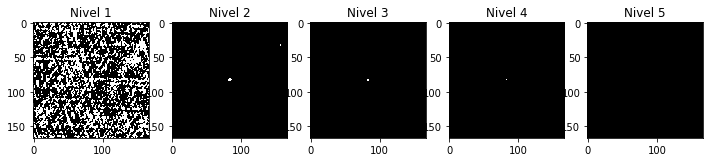

In [49]:
n_plots = n_discrete
f, ax = plt.subplots(1, n_plots, figsize=(12,15))
for i in range(0, n_discrete):
    ax[i].imshow(imgd[:,:,i], cmap='gray')
    st = 'Nivel ' + str(i + 1)
    ax[i].set_title(st)
plt.show()

In [50]:
bl = morpho.ball(1)
imgdo = morpho.opening(imgd, bl)

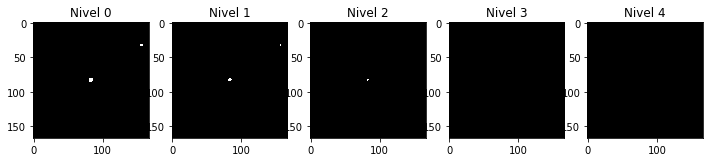

In [51]:
f, ax = plt.subplots(1, n_plots, figsize=(12,15))
for i in range(0, n_plots):
    ax[i].imshow(imgdo[:,:,i], cmap='gray')
    st = 'Nivel ' + str(i)
    ax[i].set_title(st)
plt.show()

In [52]:
@jit(nopython=True)
def white_area(img):
    area = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            area += img[i, j]
    return area
@jit(nopython=True)
def white_area3d(img):
    area = 0
    for x in range(img.shape[2]):
        area += white_area(img[:,:,x])
    return area

In [53]:
%%time
dif = white_area3d(imgd) - white_area3d(imgdo)
print (dif)

10118.0
CPU times: user 153 ms, sys: 2 ms, total: 155 ms
Wall time: 153 ms


In [56]:
def get_morphology_info(img, n_discrete):
    imgd, min_d, max_d = discretize_img(img, n_discrete)
    n_vals = int(n_discrete / 2)
    difs = np.zeros(n_vals)
    o_area = white_area3d(imgd)
    for sz in range(n_vals):
        bl = morpho.ball(sz)
        imgdo = morpho.opening(imgd, bl)
        n_area = white_area3d(imgdo)
        dif = o_area - white_area3d(imgdo)
        difs[sz] = dif
    return difs

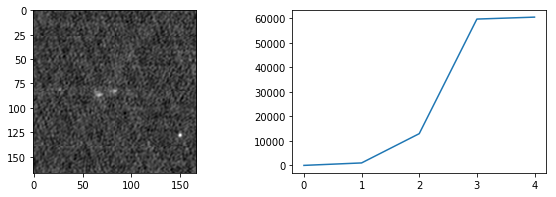

CPU times: user 548 ms, sys: 14.5 ms, total: 563 ms
Wall time: 568 ms


In [57]:
%%time
n_div = 10
f, ax = plt.subplots(1, 2, figsize=(10,3))
im = fits.open('{0}/J145627+605750.fits'.format(fits_dir))
img = sk.img_as_float(im[0].data)
ax[0].imshow(img, cmap='gray')
dat = get_morphology_info(img, n_div)
ax[1].plot(dat)
plt.show()

In [ ]:
import os
directory = os.fsencode(fits_dir)
os.listdir(directory)
n_imgs = 1000
i = 0
n_divs = 10
info = np.zeros((n_imgs, int(n_divs/2)))
names = [''] * n_imgs
for f in os.listdir(directory):
    filename = os.fsdecode(f)
    im = fits.open('{0}/{1}'.format(fits_dir, filename))
    dat = get_morphology_info(img, n_div)
    info[i] = dat
    i+= 1
    if(i >= n_imgs) : break
    im.close()